# **Introduction to Keras using a TensorFlow 2.0 Backend**

1. Loading our MNIST dataset
2. Inspecting our dataset
3. Visualizing our image dataset
5. Preprocessing our dataset
6. Building our Model
7. Training our Model
8. Plotting our training logs
9. Saving and Loading our Model
10. Testing our model on test data

## **1. Loading our Data**

There are built in datasets from ```tensorflow.keras.datasets``` to load our data. We use the ```mnist.load_data()``` function.

Returns: **2 tuples**
- x_train, x_test: uint8 array of RGB image data with shape (num_samples, 3, 32, 32) or (num_samples, 32, 32, 3) based on the image_data_format backend setting of either channels_first or channels_last respectively.
- y_train, y_test: uint8 array of category labels (integers in range 0-9) with shape (num_samples, 1).

- More info on available datases at https://keras.io/datasets/

In [2]:
# We can load the built in datasets from this function
from tensorflow.keras.datasets import mnist

# loads the MNIST training and test dataset
(x_train, y_train), (x_test, y_test)  = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


#### **A quick check to see if we're using the GPU**

In [3]:
# Check to see if we're using the GPU
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18261435620679350880
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14410383360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8652390518924961317
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## **2. Inspecting our dataset**

In [4]:
# Display the number of samples in x_train, x_test, y_train, y_test
print("Initial shape or dimensions of x_train", str(x_train.shape))

# Print the number of samples in our data
print ("Number of samples in our training data: " + str(len(x_train)))
print ("Number of labels in our training data: " + str(len(y_train)))
print ("Number of samples in our test data: " + str(len(x_test)))
print ("Number of labels in our test data: " + str(len(y_test)))

# Print the image dimensions and no. of labels in our Training and Test Data
print("\n")
print ("Dimensions of x_train:" + str(x_train[0].shape))
print ("Labels in x_train:" + str(y_train.shape))
print("\n")
print ("Dimensions of x_test:" + str(x_test[0].shape))
print ("Labels in y_test:" + str(y_test.shape))

Initial shape or dimensions of x_train (60000, 28, 28)
Number of samples in our training data: 60000
Number of labels in our training data: 60000
Number of samples in our test data: 10000
Number of labels in our test data: 10000


Dimensions of x_train:(28, 28)
Labels in x_train:(60000,)


Dimensions of x_test:(28, 28)
Labels in y_test:(10000,)


## **3. Visualizing our image dataset**

Let's take a look at some of images in this dataset
- Using Matplotlib

<Figure size 640x480 with 0 Axes>

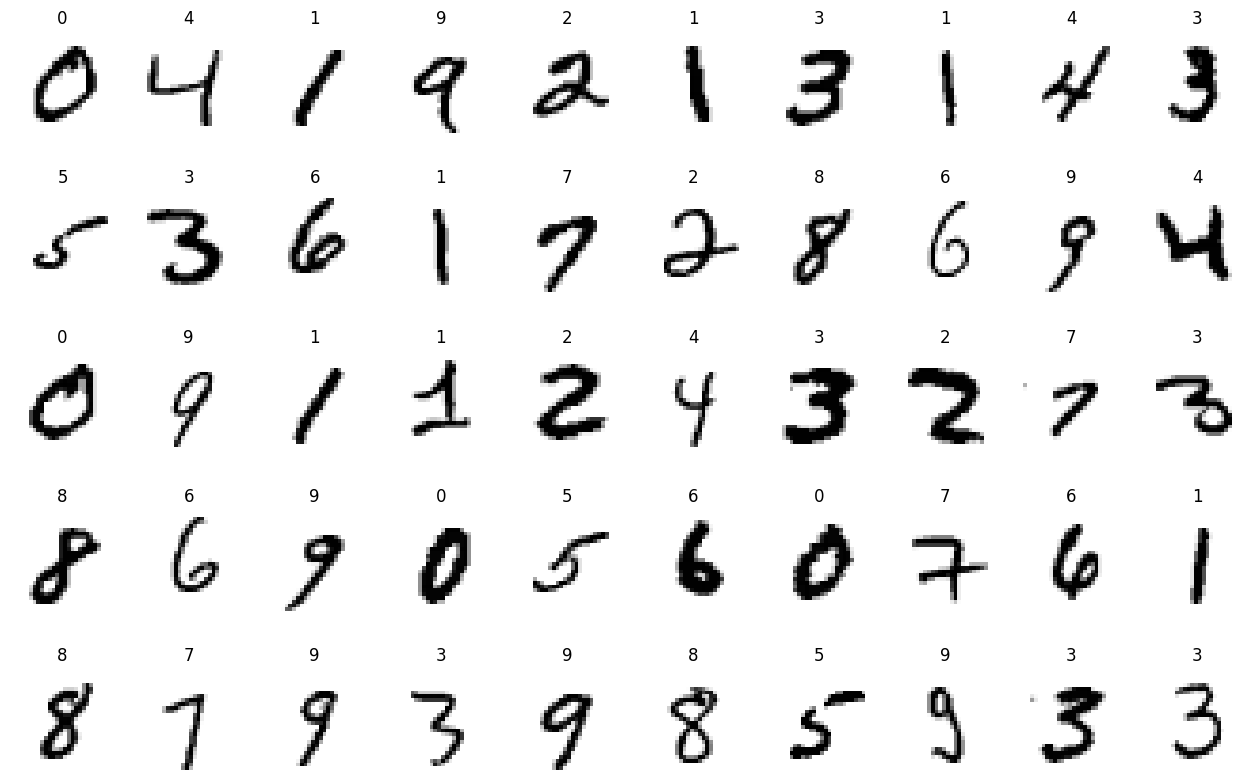

In [5]:
# Let's view the 50 first images of the MNIST training dataset
import matplotlib.pyplot as plt

# Create figure and change size
figure = plt.figure()
plt.figure(figsize=(16,10))

# Set how many images we wish to see
num_of_images = 50

# iterate index from 1 to 51
for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index).set_title(f'{y_train[index]}')
    plt.axis('off')
    plt.imshow(x_train[index], cmap='gray_r')

## **4. Preprocessing our dataset**

Before passing our data to our CNN for training, we need to prepare it firstly. This entials:
1. Reshaping our data by adding a 4th Dimension
2. Changing our datatype from uint8 to float32
3. Normalizing our data to values between 0 and 1
4. One hot encoding

In [6]:
# Lets store the number of rows and columns
img_rows = x_train[0].shape[0]
img_cols = x_train[0].shape[1]

# Getting our data in the right 'shape' needed for Keras
# We need to add a 4th dimenion to our data thereby changing our
# Our original image shape of (60000,28,28) to (60000,28,28,1)
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# store the shape of a single image
input_shape = (img_rows, img_cols, 1)

# change our image type to float32 data type
x_train = x_train.astype('float32') #uint8 originally
x_test = x_test.astype('float32')

# Normalize our data by changing the range from (0 to 255) to (0 to 1)
x_train /= 255.0
x_test /= 255.0

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


#### **One Hot Encode Our Labels**

We can easily implement this transformm using ```to_categorical``` from ``` tensorflow.keras.utils```

In [7]:
from tensorflow.keras.utils import to_categorical

# Now we one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Let's count the number columns in our hot encoded matrix
print ("Number of Classes: " + str(y_test.shape[1]))

num_classes = y_test.shape[1]
num_pixels = x_train.shape[1] * x_train.shape[2]

Number of Classes: 10


In [8]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## **5. Building Our Model**

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-29%20at%204.21.04%402x.png)
- We're constructing a simple but effective CNN that uses 32 filters of size 3x3
- We've added a 2nd CONV layer of 64 filters of the same size 3x3
- We then downsample our data to 2x2
- We then flatten our Max Pool output that is connected to a Dense/FC layer that has an output size of 128
- Then we connect our 128 outputs to another FC/Dense layer that outputs to the 10 categorical units

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

# create model
model = Sequential()

# Our First Convolution Layer, Filter size 32 which reduces our layer size to 26 x 26 x 32
# We use ReLU activation and specify our input_shape which is 28 x 28 x 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# Our Second Convolution Layer, Filter size 64 which reduces our layer size to 24 x 24 x 64
model.add(Conv2D(64, (3, 3), activation='relu'))

# We use MaxPooling with a kernel size of 2 x 2, this reduces our size to 12 x 12 x 64
model.add(MaxPooling2D(pool_size=(2, 2)))

# We then Flatten our tensor object before input into our Dense Layer
# A flatten operation on a tensor reshapes the tensor to have the shape that is
# equal to the number of elements contained in tensor
# In our CNN it goes from 12 * 12 * 64 to 9216 * 1
model.add(Flatten())

# We connect this layer to a Fully Connected/Dense layer of size 1 * 128
model.add(Dense(128, activation='relu'))

# We create our final Fully Connected/Dense layer with an output for each class (10)
model.add(Dense(num_classes, activation='softmax'))

# We compile our model, this creates an object that stores the model we just created
# We set our Optimizer to use Stochastic Gradient Descent (learning rate of 0.001)
# We set our loss function to be categorical_crossentropy as it's suitable for multiclass problems
# Finally, the metrics (What we judge our performance on) to be accuracy
model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(0.001),
              metrics = ['accuracy'])

# We can use the summary function to display our model layers and parameters
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

## **6. Training our Model**
- Our preprocessed data is used as the input
- We set the batch size to 128 (or any number ranging from 8 to 256 is good)
- We set the number of epochs to 2, this is just for this tutorial purpose, but a value for at least 10 should be used
- We store our model's training results for plotting in future
- We then use Kera's molel.evaluate function to output the model's final performance. Here we are examing Test Loss and Test Accuracy

In [10]:
batch_size = 128
epochs = 10

# Store our results here so we can plot later
# In our fit function we specify our datsets (x_train & y_train),
# the batch size (typically 16 to 128 depending on your RAM), the number of
# epochs (usually 10 to 100) and our validation datasets (x_test & y_test)
# verbose = 1, sets our training to output performance metrics every epoch
history = model.fit(x_train,
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (x_test, y_test))

Epoch 1/10
469/469 [==============================] - 15s 10ms/step - loss: 2.2222 - accuracy: 0.3469 - val_loss: 2.1039 - val_accuracy: 0.5844
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 1.7308 - accuracy: 0.6892 - val_loss: 1.1230 - val_accuracy: 0.7974
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.7607 - accuracy: 0.8267 - val_loss: 0.5185 - val_accuracy: 0.8677
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.4747 - accuracy: 0.8722 - val_loss: 0.3975 - val_accuracy: 0.8917
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 0.3972 - accuracy: 0.8887 - val_loss: 0.3525 - val_accuracy: 0.9007
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3607 - accuracy: 0.8977 - val_loss: 0.3244 - val_accuracy: 0.9074
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3362 - accuracy: 0.9040 - val_loss: 0.3069 - val_accuracy: 0.9124
Epoc

In [11]:
# We obtain our accuracy score using the evalute function
# Score holds two values, our Test loss and Accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2671593725681305
Test accuracy: 0.9236000180244446


## **7. Ploting our Loss and Accuracy Charts**

In [12]:
history_dict = history.history
history_dict

{'loss': [2.2222235202789307,
  1.7307853698730469,
  0.7607486844062805,
  0.4746677875518799,
  0.3972451388835907,
  0.3606846034526825,
  0.33624181151390076,
  0.31769365072250366,
  0.30314889550209045,
  0.29009976983070374],
 'accuracy': [0.34689998626708984,
  0.6892499923706055,
  0.8266833424568176,
  0.8722166419029236,
  0.8886666893959045,
  0.8976500034332275,
  0.904033362865448,
  0.9089000225067139,
  0.9120833277702332,
  0.9156166911125183],
 'val_loss': [2.103917121887207,
  1.122983455657959,
  0.5184577107429504,
  0.39754995703697205,
  0.3525044322013855,
  0.32437679171562195,
  0.3068818747997284,
  0.2914181053638458,
  0.2779889702796936,
  0.2671593129634857],
 'val_accuracy': [0.5843999981880188,
  0.7973999977111816,
  0.8676999807357788,
  0.891700029373169,
  0.9006999731063843,
  0.9074000120162964,
  0.9124000072479248,
  0.916100025177002,
  0.920199990272522,
  0.9236000180244446]}

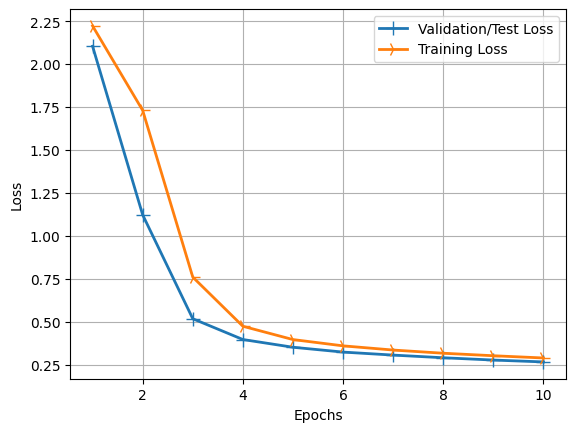

In [13]:
# Plotting our loss charts
import matplotlib.pyplot as plt

# Use the History object we created to get our saved performance results
history_dict = history.history

# Extract the loss and validation losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Get the number of epochs and create an array up to that number using range()
epochs = range(1, len(loss_values) + 1)

# Plot line charts for both Validation and Training Loss
line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

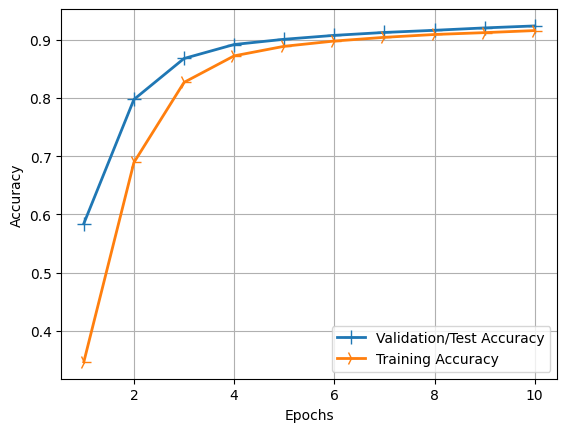

In [14]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## **8. Saving and Loadng our Model**

**Saving our Model is simple, just use:**

 ```model.save("model_file_name.h5")```

In [15]:
model.save("mnist_simple_cnn_10_Epochs.h5")
print("Model Saved")

Model Saved


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Loading our Saved Model is also simple, just use:**

```load_model(model_file_name.h5)```

In [16]:
# We need to import our load_model function
from tensorflow.keras.models import load_model

classifier = load_model('mnist_simple_cnn_10_Epochs.h5')

##  **9. Getting Predictions from our sample Test Data**

**Predicting all test data**

In [17]:
import numpy as np

#x_test = x_test.reshape(10000,28,28,1)
print(x_test.shape)

print("Predicting classes for all 10,000 test images...")

pred = np.argmax(classifier.predict(x_test), axis=-1)
print("Completed.\n")

print(pred)
print(type(pred))
print(len(pred))

(10000, 28, 28, 1)
Predicting classes for all 10,000 test images...
313/313 [==============================] - 1s 2ms/step
Completed.

[7 2 1 ... 4 5 6]
<class 'numpy.ndarray'>
10000


Actual Label: 0, Predicted Label: [0]


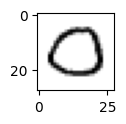

Actual Label: 5, Predicted Label: [5]


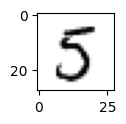

Actual Label: 4, Predicted Label: [4]


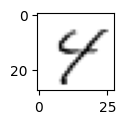

Actual Label: 4, Predicted Label: [4]


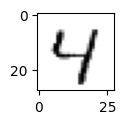

Actual Label: 3, Predicted Label: [3]


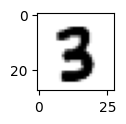

Actual Label: 5, Predicted Label: [5]


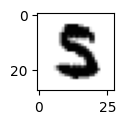

Actual Label: 2, Predicted Label: [2]


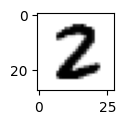

Actual Label: 4, Predicted Label: [9]


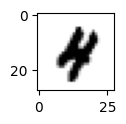

Actual Label: 3, Predicted Label: [3]


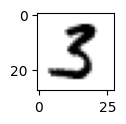

Actual Label: 5, Predicted Label: [3]


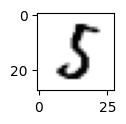

In [18]:
(x_train, y_train), (x_test, y_test)  = mnist.load_data() # reload data because we have transformed the data earlier

def imgshow(title="", image = None, size = 6):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(image, cmap='gray_r')
    plt.title(title)
    plt.show()

for i in range(0,10): # visualize 10 random samples
    rand = np.random.randint(0,len(x_test))
    img = x_test[rand] # (28, 28)
    img_reshape = img.reshape(1,28,28,1)
    pred = np.argmax(classifier.predict(img_reshape, verbose=0), axis=-1)
    label = y_test[rand]
    print(f'Actual Label: {label}, Predicted Label: {pred}')
    imgshow("", img, size = 1)